In [ ]:
#!pip install keras==2.1.6
!pip install --quiet --upgrade tensorflow-federated==0.20.0
!pip install --quiet --upgrade nest-asyncio

import nest_asyncio
nest_asyncio.apply()

     |████████████████████████████████| 819 kB 33.2 MB/s 
     |████████████████████████████████| 4.0 MB 47.8 MB/s 
     |████████████████████████████████| 237 kB 76.3 MB/s 
     |████████████████████████████████| 126 kB 64.4 MB/s 
     |████████████████████████████████| 65.1 MB 102 kB/s 
     |████████████████████████████████| 251 kB 54.6 MB/s 
     |████████████████████████████████| 887 kB 11.7 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 121 kB 52.5 MB/s 
     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 4.3 MB 44.0 MB/s 
     |████████████████████████████████| 98 kB 7.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacy 3.3.1 requires tqdm<5.0.0,>=4.38.0, but you have tqdm 4.28.1 which is incompatible.
pymc3 3.11.4 requires cachetools>=4.2.1, but 

In [ ]:
%load_ext tensorboard

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt

In [ ]:
train_data,test_data=tff.simulation.datasets.emnist.load_data()

In [ ]:
train_data.client_ids[0]

'f0000_14'

In [ ]:
train_data

In [ ]:
train_data.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [ ]:
dataset=train_data.create_tf_dataset_for_client(train_data.client_ids[0])
first=next(iter(dataset))
print(first['label'].numpy())
print()
print(first['pixels'].numpy())

1

[[1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1. 

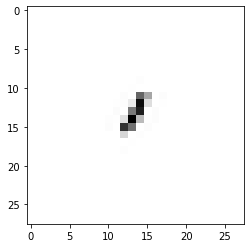

In [ ]:
plt.imshow(first['pixels'].numpy(),cmap='gray',aspect='equal')
plt.grid(False)
plt.show()

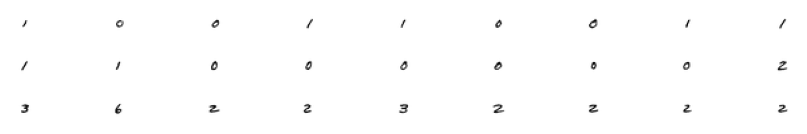

In [ ]:
fig=plt.figure(figsize=(15,3))
j=1
for client in dataset.take(27):
  plt.subplot(4,9,j)
  plt.imshow(client['pixels'].numpy(), cmap='gray', aspect='equal')
  plt.axis('off')
  j+=1

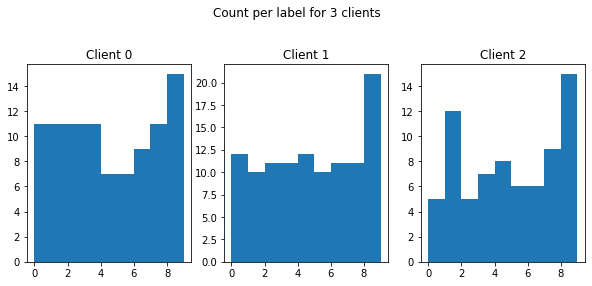

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Count per label for 3 clients')
for i in range(3):
  client_data=train_data.create_tf_dataset_for_client(train_data.client_ids[i])
  plot_data=[]
  for example in client_data:
    plot_data.append(example['label'])
  plt.subplot(2, 3, i+1)
  plt.title('Client {}'.format(i))
  plt.hist(plot_data,bins=[0,1,2,3,4,5,6,7,8,9])

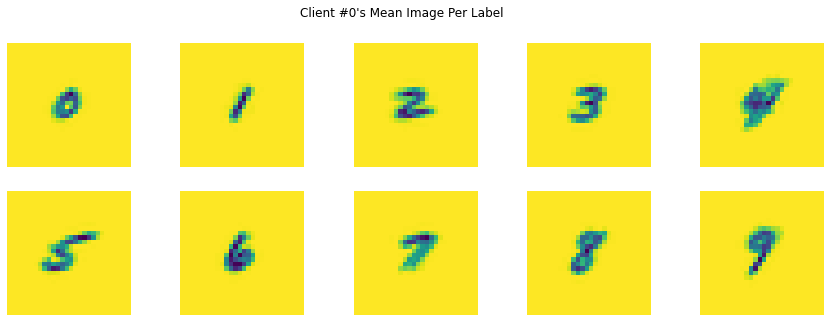

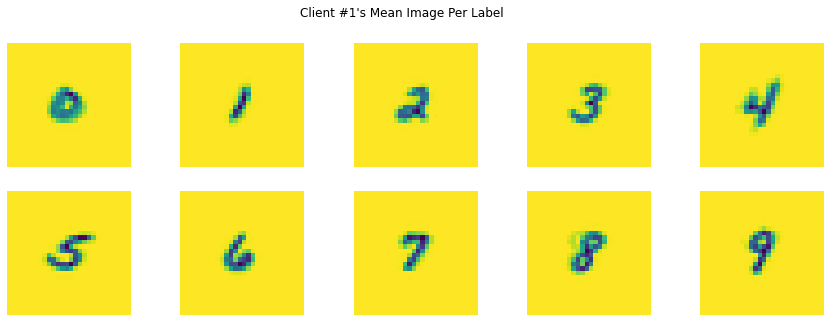

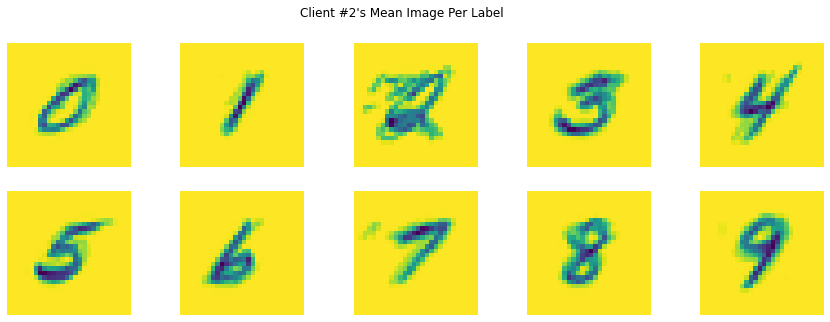

In [ ]:
import collections

for i in range(3):
  client_data=train_data.create_tf_dataset_for_client(train_data.client_ids[i])
  plot_data=collections.defaultdict(list)
  for example in client_data:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(15, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2,5,j+1)
    plt.imshow(mean_img.reshape((28,28)))
    plt.axis('off')

In [ ]:
NUM_CLIENTS = 10
BATCH_SIZE = 20

def preprocess(dataset):
  def batch_format_fn(element):
    t = element['pixels']
    t = tf.reshape(t,[-1,28,28])
    paddings = tf.constant([[0,0], [2, 2], [2, 2]])
    t = tf.pad(t,paddings,'CONSTANT',constant_values=0)
    return (tf.reshape(t, [-1, 32, 32, 1]), 
            tf.reshape(element['label'], [-1, 1]))

  return dataset.batch(BATCH_SIZE).map(batch_format_fn)

In [ ]:
preprocessed_dataset = preprocess(dataset)

mapping=tf.nest.map_structure(lambda x: x.numpy(),next(iter(preprocessed_dataset)))

mapping

(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [1.],
          ...,
          [1.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [1.],
          ...,
          [1.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [1.],
          ...,
      

In [ ]:
def make_federated_data(client_data, client_ids):
  return [preprocess(client_data.create_tf_dataset_for_client(x)) for x in client_ids]

In [ ]:
len(train_data.client_ids)

3383

In [ ]:
import random
random_list = random.sample(range(0,3383),15)
sample_clients=[]
for i in random_list:
  sample_clients.append(train_data.client_ids[i])
federated_train_data=make_federated_data(train_data,sample_clients)

In [ ]:
federated_train_data

[<MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>,
 <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), T

In [ ]:
print(f'Number of client datasets: {len(federated_train_data)}')
print(f'First dataset: {federated_train_data[0]}')

Number of client datasets: 15
First dataset: <MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>


In [ ]:
from tensorflow import keras
def create_model():
  model = keras.Sequential()
  model.add(keras.layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
  model.add(keras.layers.AveragePooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=120, activation='relu'))
  model.add(keras.layers.Dense(units=84, activation='relu'))
  model.add(keras.layers.Dense(units=10, activation = 'softmax'))
  return model

In [ ]:
def model_fn():
  model=create_model()
  return tff.learning.from_keras_model(model,input_spec=federated_train_data[0].element_spec,
                                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                                       metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Rough Cell
model_r = create_model()
vars_r = model_r.trainable_variables #A List

In [ ]:
import tensorflow_probability as tfp

@tf.function
def client_update(model, dataset, server_weights, client_optimizer):

  gamma = 1

  client_weights = model.trainable_variables
  #initial_server_weights = model.trainables
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)
  for batch in dataset:
    with tf.GradientTape() as tape:
      outputs = model.forward_pass(batch)

    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)
    client_optimizer.apply_gradients(grads_and_vars)

  similarity_arr = []  

  for i in range(len(client_weights)):
    s_w = tf.reshape(server_weights[i], [-1] )
    c_w = tf.reshape(client_weights[i], [-1] )
    similarity = gamma * tf.norm( s_w - c_w )  # Gaussian Kernel
    similarity_arr.append(similarity)

  #similarity_arr.append(tf.norm(server_weights[len(clinet_weights - 1)] - client_weights[len(clinet_weights) - 1)] ))

  '''
  #c_weights=tf.convert_to_tensor(client_weights)
  c_weights_0 = tf.convert_to_tensor(client_weights[0])
  c_weights_1 = tf.convert_to_tensor(client_weights[1])

  #s_weights=tf.convert_to_tensor(server_weights)
  s_weights_0 = tf.convert_to_tensor(server_weights[0])
  s_weights_1 = tf.convert_to_tensor(server_weights[1])
  # Flattening all the 2D matrx to find out the similarity measure
  c_w_0_flatten = tf.reshape(c_weights_0, [-1])
  c_w_1_flatten = tf.reshape(c_weights_1, [-1])
  s_w_0_flatten = tf.reshape(s_weights_0, [-1])
  s_w_1_flatten = tf.reshape(s_weights_1, [-1])

  similarity_0 = tf.tensordot(s_w_0_flatten, c_w_0_flatten, axes = 1)
  similarity_1 = tf.tensordot(s_w_1_flatten, c_w_1_flatten, axes = 1)
  similarity = (similarity_0 + similarity_1) / 2 # Avg similarity of the weight matrices of two layers

  X0 = tf.subtract(c_w_0_flatten,s_w_0_flatten)
  X0_ = tf.transpose(X0)
  cov0 = tfp.stats.covariance(x=c_w_0_flatten, y = s_w_0_flatten , sample_axis=0, event_axis=None)
  tf.print(X0_.shape)
  tf.print(cov0.shape)
  cov0 = tf.linalg.inv(cov0)
  mah0 = tf.linalg.matmul( a = X0_, b = cov0, transpose_a = True )
  mah0 = tf.linalg.matmul(mah0,X0)
  mah0 = tf.sqrt(mah0)

  X1 = tf.subtract(c_w_1_flatten,s_w_1_flatten)
  X1_ = tf.transpose(X1)
  cov1 = tfp.stats.covariance(x=c_w_1_flatten, sample_axis=0, event_axis=None)
  cov1 = tf.linalg.inv(cov1)
  print(X1.shape)
  print(cov1.shape)
  mah1 = tf.linalg.matmul(X1_,cov1)
  mah1 = tf.linalg.matmul(mah1,X1)
  mah1 = tf.sqrt(mah1)

  similarity = similarity + (mah0 + mah1) / 2

  '''

  return ( client_weights, similarity_arr )

In [ ]:
@tf.function
def server_update(model, mean_client_weights):
  model_weights = model.trainable_variables
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        model_weights, mean_client_weights)
  return model_weights

In [ ]:
@tff.tf_computation
def server_init():
  model = model_fn()
  return model.trainable_variables

@tff.federated_computation
def initialize_fn():
  return tff.federated_value(server_init(), tff.SERVER)

In [ ]:
whimsy_model = model_fn()
tf_dataset_type = tff.SequenceType(whimsy_model.input_spec)

model_weights_type = server_init.type_signature.result
print(model_weights_type)

<float32[3,3,1,6],float32[6],float32[3,3,6,16],float32[16],float32[576,120],float32[120],float32[120,84],float32[84],float32[84,10],float32[10]>


In [ ]:
@tff.tf_computation(tf_dataset_type, model_weights_type)
def client_update_fn(tf_dataset, server_weights):
  model = model_fn()
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.15)
  return client_update(model, tf_dataset, server_weights, client_optimizer)

In [ ]:
@tff.tf_computation
def server_update_fn(mean_client_weights):
  model = model_fn()
  return server_update(model, mean_client_weights)

In [ ]:
federated_server_type = tff.FederatedType(model_weights_type, tff.SERVER)
federated_dataset_type = tff.FederatedType(tf_dataset_type, tff.CLIENTS)

In [ ]:
@tff.federated_computation(federated_server_type, federated_dataset_type)
def next_fn(server_weights, federated_dataset):
  server_weights_at_client = tff.federated_broadcast(server_weights)
  #c_weights
  ( client_weights, similarity_arr ) = tff.federated_map( client_update_fn, ( federated_dataset, server_weights_at_client ) )
  #similarity = 1
  #attentions=client_update_fn(federated_dataset, server_weights_at_client)[1]
  #client_weights = tff.federated_map(c_weights,(federated_dataset, server_weights_at_client))
  #attentions = tff.federated_map(attentions,(federated_dataset, server_weights_at_client))
  #mean_client_weights = tff.federated_sum(attentions)
  mean_client_weights = []
  for i in range( len( client_weights ) ):
    mean_client_weights.append( tff.federated_mean( client_weights[i], similarity_arr[i] ) )
  #mean_client_weights = tff.federated_mean(client_weights, similarity)
  server_weights = tff.federated_map(server_update_fn, mean_client_weights)

  return server_weights

In [ ]:
federated_algorithm = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn,
    next_fn=next_fn
)

In [ ]:
str(federated_algorithm.initialize.type_signature)

'( -> <float32[3,3,1,6],float32[6],float32[3,3,6,16],float32[16],float32[576,120],float32[120],float32[120,84],float32[84],float32[84,10],float32[10]>@SERVER)'

In [ ]:
str(federated_algorithm.next.type_signature)

'(<server_weights=<float32[3,3,1,6],float32[6],float32[3,3,6,16],float32[16],float32[576,120],float32[120],float32[120,84],float32[84],float32[84,10],float32[10]>@SERVER,federated_dataset={<float32[?,32,32,1],int32[?,1]>*}@CLIENTS> -> <float32[3,3,1,6],float32[6],float32[3,3,6,16],float32[16],float32[576,120],float32[120],float32[120,84],float32[84],float32[84,10],float32[10]>@SERVER)'

#### Evaluating the Algorithm

In [ ]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
central_emnist_test = emnist_test.create_tf_dataset_from_all_clients()
central_emnist_test = preprocess(central_emnist_test)

In [ ]:
central_emnist_test

<MapDataset element_spec=(TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))>

In [ ]:
def evaluate(server_state):
  keras_model = create_model()
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]  
  )
  keras_model.set_weights(server_state)
  keras_model.evaluate(central_emnist_test)

In [ ]:
server_state = federated_algorithm.initialize()
evaluate(server_state)

2042/2042 [==============================] - 8s 4ms/step - loss: 2.3019 - sparse_categorical_accuracy: 0.1007


In [ ]:
for round in range(100):
  server_state = federated_algorithm.next(server_state, federated_train_data)
  evaluate(server_state)

2042/2042 [==============================] - 8s 4ms/step - loss: 0.7613 - sparse_categorical_accuracy: 0.7531


In [ ]:
for round in range(15):
  server_state = federated_algorithm.next(server_state, federated_train_data)
  evaluate(server_state)

2042/2042 [==============================] - 8s 4ms/step - loss: 0.6904 - sparse_categorical_accuracy: 0.7838


In [ ]:
for round in range(15):
  server_state = federated_algorithm.next(server_state, federated_train_data)
  evaluate(server_state)

2042/2042 [==============================] - 8s 4ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.8036


In [ ]:
evaluate(server_state)

2042/2042 [==============================] - 10s 5ms/step - loss: 0.6382 - sparse_categorical_accuracy: 0.8036
